In [1]:
import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt

In [18]:
psi = np.load('/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/x_stoch.npy')

In [19]:
lead = 1

trainN = 200000
valN = 50000
index = 63

psi = psi[:,0,:]

print(psi.shape)
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi

psi_train_input = torch.tensor(psi[0:trainN,:])
psi_train_label =  torch.tensor(psi[lead:trainN+lead,:])

indices = np.random.permutation(np.arange(start=0, step=1,stop=trainN))

u_train_input_shuffle = psi_train_input[indices]
u_train_label_shuffle = psi_train_label[indices]

psi_val_input = torch.tensor(psi[trainN:trainN+valN,:])
psi_val_label =  torch.tensor(psi[trainN+1:trainN+valN+lead,:])

print(psi_train_input.shape)
print(psi_train_label.shape)
print(psi_val_input.shape)
print(psi_val_label.shape)

(299400, 75)
torch.Size([200000, 75])
torch.Size([200000, 75])
torch.Size([50000, 75])
torch.Size([50000, 75])


In [4]:
print(np.shape(psi))

(299400, 75)


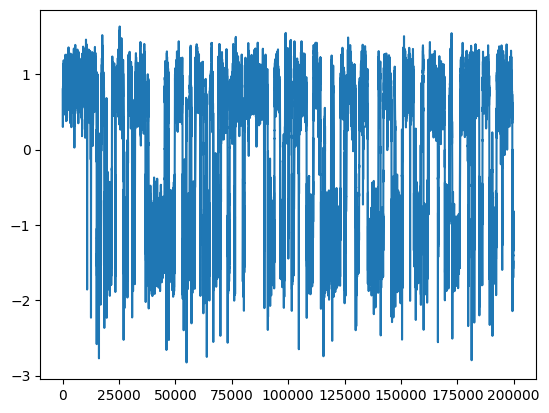

In [5]:
plt.plot(psi_train_input[0:200000,60])

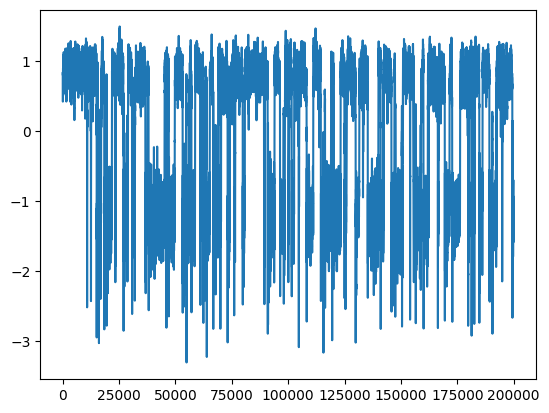

In [6]:
import matplotlib.pyplot as plt
plt.plot(psi_train_input[0:200000,63])

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(64, 64)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_mu = nn.Linear(64, latent_dim)  # Hidden layer (128) -> Latent space (2)
        self.fc_logvar = nn.Linear(64, latent_dim)  # Hidden layer (128) -> Log variance (2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, 64)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(64, 64)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(64, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z))
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition)
        return output, mu, logvar





In [ ]:
input_dim = 75
output_dim = 75
latent_dim = 64
condition_dim = 75
batch_size = 256
num_epochs = 5

# Initialize the model, optimizer, and loss function
model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
for epoch in range(num_epochs):
    model.train()
    for batch in range (0, trainN, batch_size):

        input_batch = u_train_input_shuffle[batch:batch + batch_size,:]
        label_batch = u_train_label_shuffle[batch:batch + batch_size,:]

        optimizer.zero_grad()

        output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda())

        # Reconstruction loss
        reconstruction_loss = ((output - label_batch.float().cuda()) ** 2).sum()

        # KL divergence loss
        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        
        # Total loss
        loss = reconstruction_loss + 0.01 * kl_loss

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Validation Loss
    model.eval()
    for batch in range (0, valN, batch_size):

        input_batch = psi_val_input[batch:batch + batch_size,:]
        label_batch = psi_val_label[batch:batch + batch_size,:]

        input_batch = u_train_input_shuffle[batch:batch + batch_size,:]
        label_batch = u_train_label_shuffle[batch:batch + batch_size,:]
        output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda())
        reconstruction_loss = ((output - label_batch.float().cuda()) ** 2).sum()
        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        loss = reconstruction_loss + 0.01 * kl_loss

    print(f'Val Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 53.42512512207031
Val Epoch 1, Loss: 55.038848876953125
Epoch 2, Loss: 27.94074058532715
Val Epoch 2, Loss: 36.16071701049805
Epoch 3, Loss: 24.88831901550293
Val Epoch 3, Loss: 27.953763961791992
Epoch 4, Loss: 21.287033081054688
Val Epoch 4, Loss: 23.31806182861328
Epoch 5, Loss: 19.32057762145996
Val Epoch 5, Loss: 23.113204956054688


In [ ]:
initial_cond = torch.reshape(torch.tensor(psi[0,:]), [1, 75])
time_step = 30000
z = torch.zeros([1,latent_dim])
num_ens = 10
pred = np.zeros ([time_step, 75, num_ens])


for k in range (0, time_step):

  for ens in range (0, num_ens):
       if (k ==0):

        z = torch.randn_like(z)
        print(z.shape, initial_cond.shape)
        y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()
        pred[k,:,ens] = y
        y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
        initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

       else:
        select_ens = np.random.randint(0,num_ens,1)
        z = torch.randn_like(z)
        y = (model.decode(z.float().cuda(),torch.reshape(torch.tensor(pred[k-1,:,select_ens]),[1,75]).float().cuda())).detach().cpu().numpy()
        pred[k,:, ens] = y
        y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
        initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

    


# Denormalize final preds
print(std_psi[:, 63])
pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

# Denormalize test labels
actual_values = psi_train_label[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
print(actual_values)




torch.Size([1, 64]) torch.Size([1, 75])
torch.Size([1, 64]) torch.Size([1, 75])
torch.Size([1, 64]) torch.Size([1, 75])
torch.Size([1, 64]) torch.Size([1, 75])
torch.Size([1, 64]) torch.Size([1, 75])
torch.Size([1, 64]) torch.Size([1, 75])
torch.Size([1, 64]) torch.Size([1, 75])
torch.Size([1, 64]) torch.Size([1, 75])
torch.Size([1, 64]) torch.Size([1, 75])
torch.Size([1, 64]) torch.Size([1, 75])
[10.46789208]
tensor([22.8322, 23.0207, 22.9245,  ..., 23.9922, 23.9619, 23.9700],
       dtype=torch.float64)


In [86]:
print(std_psi.shape)

(1, 75)


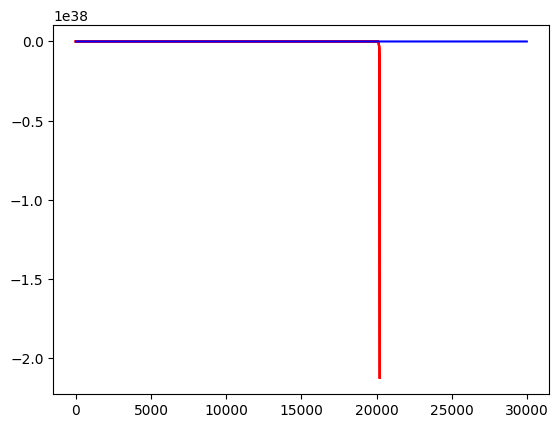

In [87]:
plt.plot(pred_mean[0:30000,63],'r')
plt.plot(actual_values[0:30000],'b')


In [ ]:
np.random.randint(0,9,1)

array([3])

In [84]:
np.savez(r'/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/predictions' ,
         predictions=pred_mean, mean_psi=mean_psi, std_psi=std_psi, actual_values=actual_values)